### Importing all necessary libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
pd.set_option("display.max_colwidth", 200)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set()

### Loading files

In [2]:
df_train = pd.read_csv('./data/train.csv',encoding='utf-8')
df_test =  pd.read_csv('./data/test.csv',encoding='utf-8')

In [3]:
df_train.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1


In [4]:
df_test.head()

,tweet_id,tweet,sentiment,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,7506,"Audience Q: What prototyping tools do you use? Sketchbooks/sharpie pens, photoshop, Balsamic, Google docs, Axsure, etc. #myprototype #sxsw",1,NaN,"[0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]",NaN
1,7992,At SXSW? Send Your Best Photos &amp; Videos to... {link} #citizen_journalism #cnn #ireport #photography #sxsw #Cyber #iPhone,1,NaN,NaN,NaN
2,247,@mention and here's a pic of you winning your ipad! #unsix #sxsw cc @mention @mention {link} (cont) {link},1,NaN,0,negative
3,7688,Google Marissa Mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like #sxsw,2,NaN,1,neutral
4,3294,#SXSW Google maps is even cooler than I thought,2,NaN,2,postive


In [5]:
#df_train.drop(df_train[df_train['sentiment'] == 3].index, inplace=True)

# Data Inspection

In [6]:
print('Shape of training dataset',df_train.shape)
print('Shape of training dataset',df_test.shape)

Shape of training dataset (7274, 3)
Shape of training dataset (1819, 6)


In [7]:
df_train.isnull().sum()

tweet_id     0
tweet        1
sentiment    0
dtype: int64

### Since only one row contains null value so we decided to drop

In [8]:
df_train.tweet.dropna(axis=0, inplace=True)

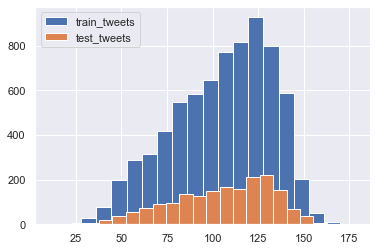

In [9]:
length_train = df_train['tweet'].str.len()
length_test = df_test['tweet'].str.len()
plt.hist(length_train, bins=20, label="train_tweets") 
plt.hist(length_test, bins=20, label="test_tweets") 
plt.legend() 
plt.show()

In [10]:
df_train.reset_index(drop=True, inplace=True)

### Length of training tweets is much higher than testing tweets which makes dataset good to go

In [11]:
df_train.sentiment.value_counts()

1    4311
2    2382
0     456
3     125
Name: sentiment, dtype: int64

In [12]:
4311*100/7274 ## neutral

59.26587847126753

In [13]:
2382*100/7274 ## positive

32.74676931536981

In [14]:
456*100/7274 ## negative

6.268902941985153

In [15]:
125*100/7274 ## cantsay

1.718449271377509

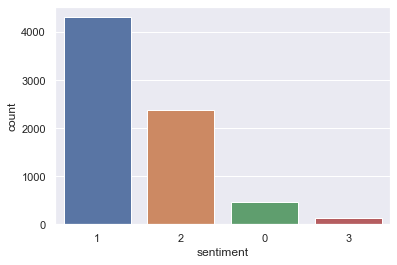

In [16]:
sns.countplot(df_train.sentiment,order=df_train.sentiment.value_counts().index)

### Above graph shows that the dataset is imbalance 

In [17]:
df_train[df_train.tweet.duplicated()==True].count()

tweet_id     18
tweet        18
sentiment    18
dtype: int64

In [18]:
df_train[df_train.tweet.duplicated()==True]

,tweet_id,tweet,sentiment
1473,6300,RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,1
1832,6298,RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,2
2039,5880,"RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW",1
2165,3813,Win free ipad 2 from webdoc.com #sxsw RT,2
2823,6293,RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW,2
2855,6294,RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,1
3194,5881,"RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",1
3267,3814,Win free iPad 2 from webdoc.com #sxsw RT,2
3867,6296,RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,2
4180,5341,"RT @mention ÷¼ Happy Woman's Day! Make love, not fuss! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter",1


### There were misclassifications in training data itself(Proof : tweet_id :- 6300,6298 and so on) so we decided to drop this duplicate data  

In [19]:
df_train.drop_duplicates(['tweet'],inplace=True)
df_train.shape

(7256, 3)

In [20]:
def count_regex(pattern, tweet):
    return len(re.findall(pattern, tweet))

In [21]:
count_mentions = df_train['tweet'].astype(str).apply(lambda x:count_regex(r'@\w+', x))

In [22]:
len(count_mentions)

7256

In [23]:
df_train['count_mentions'] = pd.DataFrame(count_mentions)

In [24]:
df_train

,tweet_id,tweet,sentiment,count_mentions
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,0
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1,0
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2,1
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0,0
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1,0
...,...,...,...,...
7269,3343,@mention Google plze Tammi. I'm in middle of #SXSW craziness and everything is soooooo busy!,1,1
7270,5334,RT @mention ÷¼ Are you all set? ÷_ {link} ÷_ #edchat #musedchat #sxsw #sxswi #newTwitter,1,1
7271,5378,"RT @mention Aha! Found proof of lactation room, excuse me, &quot;Mother's Room,&quot; brought to you by Google, at last year's #SXSW. {link}",1,1
7272,2173,We just launched our iPad app at #SXSW! Get all the details + the first edition FREE: {link},1,0


In [25]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df_train.groupby('sentiment')[col].describe())
    bins = np.arange(df_train[col].min(), df_train[col].max() + 1)
    g = sns.FacetGrid(df_train, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0           455.0  0.553846  0.739733  0.0  0.0  0.0  1.0  4.0
1          4301.0  0.850035  0.977452  0.0  0.0  1.0  1.0  8.0
2          2375.0  0.741053  0.838658  0.0  0.0  1.0  1.0  5.0
3           125.0  0.640000  0.962188  0.0  0.0  0.0  1.0  5.0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


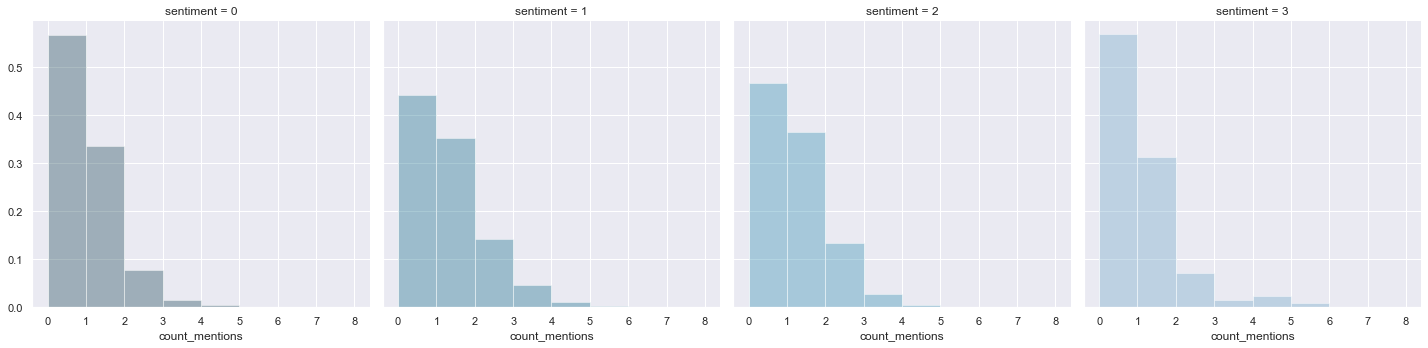

In [26]:
show_dist(df_train,'count_mentions')

# Data Cleaning

### Replacing all short word in to proper word

In [27]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [28]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [29]:
df_train['clean_tweet'] = df_train['tweet'].astype(str).apply(lambda x: lookup_dict(x,apostrophe_dict))
df_train.head(10)

,tweet_id,tweet,sentiment,count_mentions,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,0,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1,0,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw"
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2,1,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}"
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0,0,This iPhone #SXSW app would b pretty awesome if it did not crash every 10mins during extended browsing. #Fuckit #Illmakeitwork
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1,0,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link}
5,966,#technews One lone dude awaits iPad 2 at AppleÛªs SXSW store {link} #Tech_News #Apple #iPad_2 #SXSW #tablets #tech,1,0,#technews One lone dude awaits iPad 2 at AppleÛªs SXSW store {link} #Tech_News #Apple #iPad_2 #SXSW #tablets #tech
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping With Zuckerberg.\r\n{link} #sxsw #ipad",1,0,"SXSW Tips, Prince, NPR Videos, Toy Shopping With Zuckerberg.\r\n{link} #sxsw #ipad"
7,8182,NU user RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable,1,1,NU user RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2,0,Free #SXSW sampler on iTunes {link} #FreeMusic
9,883,I think I might go all weekend without seeing the same iPad case twice... #sxsw,2,0,I think I might go all weekend without seeing the same iPad case twice... #sxsw


In [30]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [31]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: lookup_dict(x,short_word_dict))
df_train.head(90)

,tweet_id,tweet,sentiment,count_mentions,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,0,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1,0,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw"
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2,1,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}"
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0,0,This iPhone #SXSW app would b pretty awesome if it did not crash every 10mins during extended browsing. #Fuckit #Illmakeitwork
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1,0,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link}
...,...,...,...,...,...
85,4583,Google's new social network &quot;Circles&quot; being announced today?? #sxsw,1,0,Google's new social network &quot;Circles&quot; being announced today?? #sxsw
86,7077,Apple to Open Pop-Up Shop at SXSW [REPORT]: {link} #sxsw,1,0,Apple to Open Pop-Up Shop at SXSW [REPORT]: {link} #sxsw
87,5399,RT @mention Any iPAD2's left at the Apple store at #SXSW? Anyone know? :),1,1,RT @mention Any iPAD2's left at the Apple store at #SXSW? Anyone know? :)
88,1438,@mention :New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable {link},1,1,@mention :New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable {link}


In [32]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":@": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad",
":‑O": "suprise",
":O": "suprise",
":‑o": "suprise",
":o": "suprise",
":-0": "suprise",
"8‑0": "shock",
">:O": "yawn",
":‑|": "no expression",
":|": "indecision",
"|;‑)": "cool",
"|‑O": "bored",
"%‑)": "confused",
"%)": "confused",
"',:-|": "disaproval",
"',:-l": "disaproval"
}

In [33]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))
df_train.head(10)

,tweet_id,tweet,sentiment,count_mentions,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,0,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1,0,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw"
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2,1,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}"
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0,0,This iPhone #SXSW app would b pretty awesome if it did not crash every 10mins during extended browsing. #Fuckit #Illmakeitwork
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1,0,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link}
5,966,#technews One lone dude awaits iPad 2 at AppleÛªs SXSW store {link} #Tech_News #Apple #iPad_2 #SXSW #tablets #tech,1,0,#technews One lone dude awaits iPad 2 at AppleÛªs SXSW store {link} #Tech_News #Apple #iPad_2 #SXSW #tablets #tech
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping With Zuckerberg.\r\n{link} #sxsw #ipad",1,0,"SXSW Tips, Prince, NPR Videos, Toy Shopping With Zuckerberg.\r\n{link} #sxsw #ipad"
7,8182,NU user RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable,1,1,NU user RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2,0,Free #SXSW sampler on iTunes {link} #FreeMusic
9,883,I think I might go all weekend without seeing the same iPad case twice... #sxsw,2,0,I think I might go all weekend without seeing the same iPad case twice... #sxsw


In [34]:
df_train['tweet'] = df_train['tweet'].str.lower()

In [35]:
# function to collect hashtags 
def hashtag_extract(x):    
    hashtags = []    # Loop over the words in the tweet   
    for i in x:        
        ht = re.findall(r"#(\w+)", i)        
        hashtags.append(ht)     
    return hashtags

# extracting hashtags from negative tweets 
HT_negative = hashtag_extract(df_train['tweet'][df_train['sentiment'] == 0].astype(str)) 
# extracting hashtags from positive tweets 
HT_positive = hashtag_extract(df_train['tweet'][df_train['sentiment'] == 2].astype(str))
# extracting hashtags from neutral tweets
HT_neutral = hashtag_extract(df_train['tweet'][df_train['sentiment'] == 1].astype(str))
# extracting hashtags from cantsay tweets
HT_cantsay = hashtag_extract(df_train['tweet'][df_train['sentiment'] == 3].astype(str))

In [36]:
HT_negative_s = sum(HT_negative,[])
HT_positive_s = sum(HT_positive,[])
HT_neutral_s = sum(HT_neutral,[])
HT_cantsay_s = sum(HT_cantsay,[])

In [37]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image as im
mask = np.array(Image.open('hashtag.jpg'))

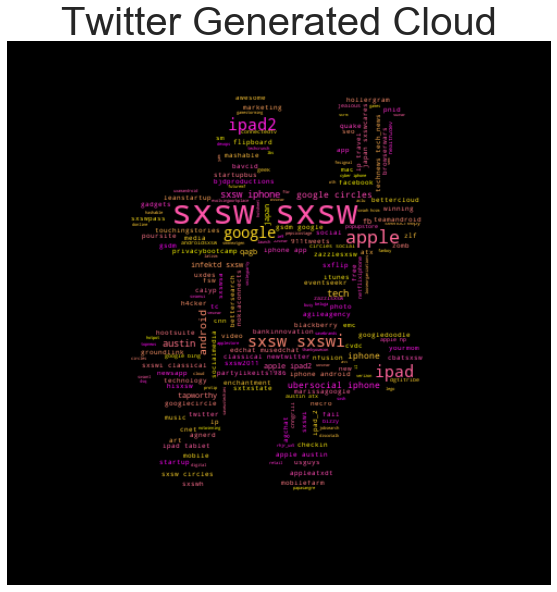

In [38]:
wc = WordCloud(background_color="black", max_words=4000, mask=mask,colormap='spring')
clean_string = ','.join(HT_negative_s+HT_positive_s+HT_neutral_s+HT_cantsay_s)
wc.generate(clean_string)
f = plt.figure(figsize=(10,10))
#f.add_subplot(1,2, 1)
# plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
# plt.title('Original Stencil', size=40)
# plt.axis("off")
#f.add_subplot(1,2, 2)
plt.imshow(wc, interpolation='bilinear')
plt.title('Twitter Generated Cloud', size=40)
plt.axis("off")
plt.show()

In [39]:
print("Hashtag count in Negative Tweet -",len(HT_negative_s))
print("Hashtag count in Positive Tweet -",len(HT_positive_s))
print("Hashtag count in Neutral Tweet -",len(HT_neutral_s))
print("Hashtag count in Can't say Tweet -",len(HT_cantsay_s))

Hashtag count in Negative Tweet - 730
Hashtag count in Positive Tweet - 4002
Hashtag count in Neutral Tweet - 7706
Hashtag count in Can't say Tweet - 200


In [40]:
label = ['Neutral','Positive','Negative','Cant say']
counts=[7706,4002,730,200]

In [41]:
df_train.shape[0]

7256

In [42]:
(7256-29)/7256

0.9960033076074972

### 99% tweets are hashtag

In [43]:
df_train[df_train.sentiment ==3].shape

(125, 5)

In [44]:
(4301-15)/4301

0.9965124389676819

In [45]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(label, counts)
    plt.xlabel('Sentiments', fontsize=10)
    plt.ylabel('Counts', fontsize=10)
    plt.xticks(index, label, fontsize=10)
    plt.show()
    sns.set

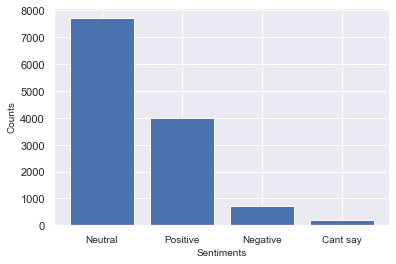

In [46]:
plot_bar_x()

### We can conclude that Neutral tweets are more hashtagged as compare to  Positive,Negative and Can't say.

In [47]:
df_train['hashtags'] = df_train['tweet'].astype(str).apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df_train_sort_hashtags = df_train.sort_values(by='hashtags', ascending=False)
df_train_sort_hashtags[['tweet', 'hashtags']].head()

,tweet,hashtags
6086,ipad 2 and its rivals: how they stack up {link} #bnet #biz #ipad2 #apple #sxsw #ipad #tablet #xoom #tech #laptop #pics #sale,12
865,rt @mention ipad 2 and its rivals: how they stack up {link} #bnet #biz #ipad2 #apple #sxsw #ipad #tablet #xoom #tech #laptop #pics #sale,12
2382,amex teams up with foursquare {link} #gps #sxsw #social #commerce #credit #app #android #iphone #blackberry #viral #media,11
2759,"#sxsw (2): #gamification, #ipad #design, mobile #banking &amp; #marketing 2.0 {link} #artikelen #dossiers #events #mediapers",10
1256,#sxsw #japan #sendai #prayforjapan #beforetwitter #ipad #tiesto #hotel #airplane #food,10


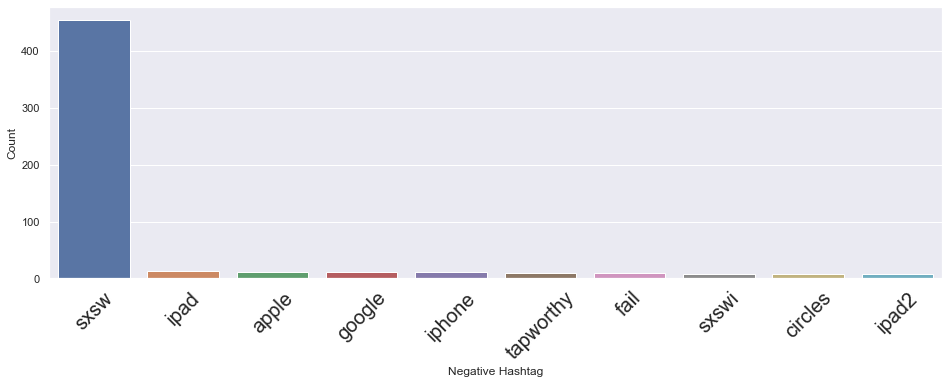

In [48]:
from nltk.probability import FreqDist
a = nltk.FreqDist(HT_negative_s) 
d = pd.DataFrame({'Negative Hashtag': list(a.keys()),'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "Negative Hashtag", y = "Count") 
ax.set(ylabel = 'Count') 
plt.xticks(rotation=45, fontsize=20)
plt.show()

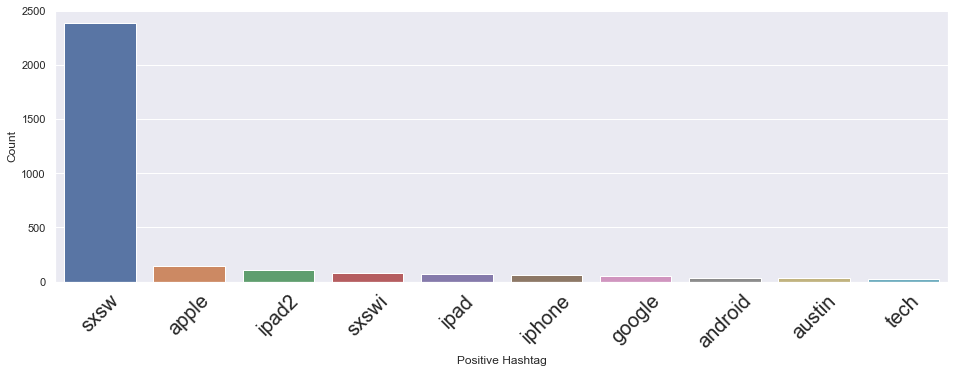

In [49]:
from nltk.probability import FreqDist
a = nltk.FreqDist(HT_positive_s) 
d = pd.DataFrame({'Positive Hashtag': list(a.keys()),'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "Positive Hashtag", y = "Count") 
ax.set(ylabel = 'Count') 
plt.xticks(rotation=45, fontsize=20)
plt.show()

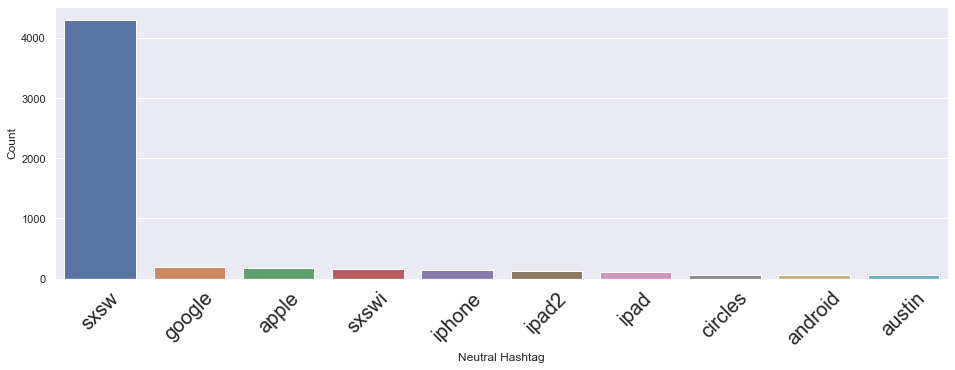

In [50]:
from nltk.probability import FreqDist
a = nltk.FreqDist(HT_neutral_s) 
d = pd.DataFrame({'Neutral Hashtag': list(a.keys()),'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "Neutral Hashtag", y = "Count") 
ax.set(ylabel = 'Count') 
plt.xticks(rotation=45, fontsize=20)
plt.show()

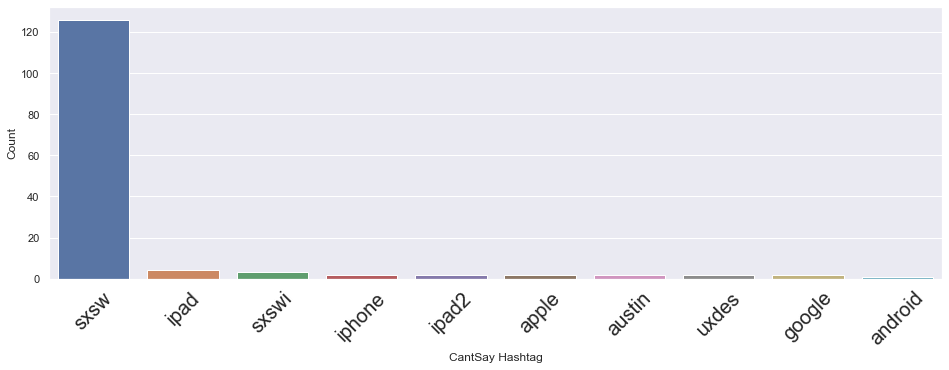

In [51]:
from nltk.probability import FreqDist
a = nltk.FreqDist(HT_cantsay_s) 
d = pd.DataFrame({'CantSay Hashtag': list(a.keys()),'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "CantSay Hashtag", y = "Count") 
ax.set(ylabel = 'Count') 
plt.xticks(rotation=45, fontsize=20)
plt.show()

### Sxsw is the most dominant word irrespective of the sentiment.we will keep this sxsw hashtag as it is the name of the event and should contain useful information. 


# Data Cleaning and Pre-Processing

In [52]:
# function to remove user handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, str(input_txt))
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return str(input_txt)

In [53]:
# remove user handles
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda row:remove_pattern(row, "@[a-zA-Z0-9_]*"))

### We will remove the twitter handles as they are already masked as @mention due to privacy concerns. These twitter handles hardly give any information about the nature of the tweet.


In [54]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda row:remove_pattern(row, "#"))

### Removing all # tag because it dont not make any sense

In [55]:
df_train['clean_tweet'] = df_train['clean_tweet'].str.replace("[^a-zA-Z]", " ") 

### We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

In [56]:
df_train['clean_tweet'] = df_train['clean_tweet'].str.lower()

### converting all the text to lowercase

In [57]:
df_train['clean_tweet']=df_train['clean_tweet'].str.replace('rt','retweet')

In [58]:
def RT_extract(x):    
    RTs = []    # Loop over the words in the tweet   
    for i in x:        
        rt = re.findall(r"retweet", i)        
        RTs.append(rt)     
    return RTs

In [59]:
df_train[df_train['sentiment'] == 0].shape[0]

455

In [60]:
retweet =[]
retweet_count =[]
for i in range(0,4):
    test=nltk.FreqDist(sum(RT_extract(df_train['clean_tweet'][df_train['sentiment'] == i]),[])) 
    retweet_count.append(test)
    retweet.append(test.get('retweet')*100/df_train[df_train['sentiment'] == i].shape[0])
    print(retweet_count[i],retweet[i])

<FreqDist with 1 samples and 170 outcomes> 37.362637362637365
<FreqDist with 1 samples and 2139 outcomes> 49.73262032085562
<FreqDist with 1 samples and 1203 outcomes> 50.65263157894737
<FreqDist with 1 samples and 47 outcomes> 37.6


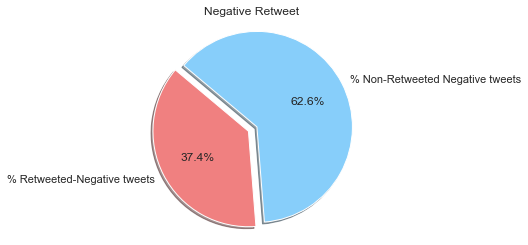

In [61]:
labels = '% Retweeted-Negative tweets', '% Non-Retweeted Negative tweets'
sizes = [retweet[0], 100-retweet[0]]
colors = [ 'lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Negative Retweet')
plt.axis('equal')
plt.show()

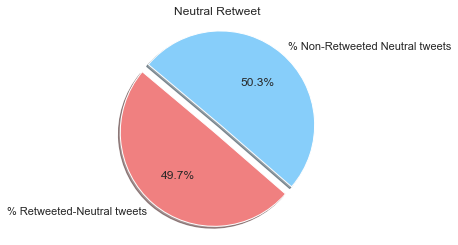

In [62]:
labels = '% Retweeted-Neutral tweets', '% Non-Retweeted Neutral tweets'
sizes = [retweet[1], 100-retweet[1]]
colors = [ 'lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Neutral Retweet')
plt.axis('equal')
plt.show()

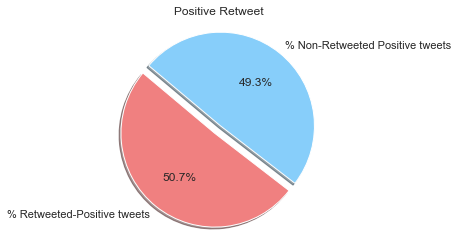

In [63]:
labels = '% Retweeted-Positive tweets', '% Non-Retweeted Positive tweets'
sizes = [retweet[2], 100-retweet[2]]
colors = [ 'lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Positive Retweet')
plt.axis('equal')
plt.show()

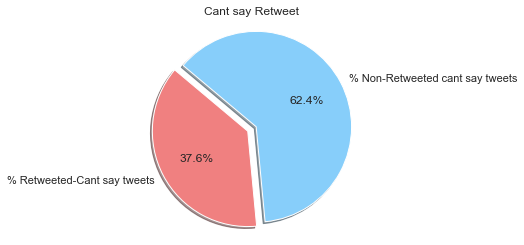

In [64]:
labels = '% Retweeted-Cant say tweets', '% Non-Retweeted cant say tweets'
sizes = [retweet[3], 100-retweet[3]]
colors = [ 'lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Cant say Retweet')
plt.axis('equal')
plt.show()

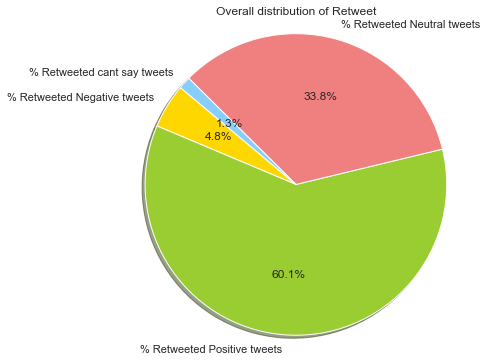

In [65]:
labels = '% Retweeted Negative tweets', '% Retweeted Positive tweets','% Retweeted Neutral tweets','% Retweeted cant say tweets'
sizes = [4.77,60.10,33.8,1.32]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)   # explode 1st slice
plt.figure(figsize=(6,6))
# Plot
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Overall distribution of Retweet')
plt.axis('equal')
plt.show()

### We can conclude that positive tweets are getting retweeted frequently followed by Neutral,Negative and Can't say.

In [66]:
test.get('retweet')*100/df_train[df_train['sentiment'] == 1].shape[0]

1.0927691234596606

In [67]:
df_train[df_train['sentiment'] == 0].shape[0]

455

In [68]:
df_train['clean_tweet'] = df_train['clean_tweet'].astype(str).apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

### Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

In [69]:
df_train['clean_tweet']=df_train['clean_tweet'].str.replace('link','')

### Remove "Link " word 

In [70]:
df_train.head(50)

,tweet_id,tweet,sentiment,count_mentions,clean_tweet,hashtags
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,0,sxswnui sxsw apple defining language touch with different dialects becoming smaller,3
1,1851,"learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw",1,0,learning google doodles all doodles should light funny amp innovative with exceptions for significant occasions googledoodle sxsw,2
2,2689,"one of the most in-your-face ex. of stealing the show in yrs rt @mention &quot;at #sxsw, apple schools the mkt experts&quot; {link}",2,1,one the most your face stealing the show yrs retweet quot sxsw apple schools the mkt experetweets quot,1
3,4525,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,0,0,this iphone sxsw app would pretty awesome did not crash every mins during extended browsing fuckit illmakeitwork,3
4,3604,line outside the apple store in austin waiting for the new ipad #sxsw {link},1,0,line outside the apple store austin waiting for the new ipad sxsw,1
5,966,#technews one lone dude awaits ipad 2 at appleûªs sxsw store {link} #tech_news #apple #ipad_2 #sxsw #tablets #tech,1,0,technews one lone dude awaits ipad apple sxsw store tech news apple ipad sxsw tablets tech,7
6,1395,"sxsw tips, prince, npr videos, toy shopping with zuckerberg.\r\n{link} #sxsw #ipad",1,0,sxsw tips prince npr videos toy shopping with zuckerberg sxsw ipad,2
7,8182,nu user rt @mention new #ubersocial for #iphone now in the app store includes uberguide to #sxsw sponsored by #mashable,1,1,user retweet new ubersocial for iphone now the app store includes uberguide sxsw sponsored mashable,4
8,8835,free #sxsw sampler on itunes {link} #freemusic,2,0,free sxsw sampler itunes freemusic,2
9,883,i think i might go all weekend without seeing the same ipad case twice... #sxsw,2,0,think might all weekend without seeing the same ipad case twice sxsw,1


In [71]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
df_train['word count'] = df_train['tweet'].astype(str).apply(word_count)
df_train.head(3)

,tweet_id,tweet,sentiment,count_mentions,clean_tweet,hashtags,word count
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,0,sxswnui sxsw apple defining language touch with different dialects becoming smaller,3,12
1,1851,"learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw",1,0,learning google doodles all doodles should light funny amp innovative with exceptions for significant occasions googledoodle sxsw,2,19
2,2689,"one of the most in-your-face ex. of stealing the show in yrs rt @mention &quot;at #sxsw, apple schools the mkt experts&quot; {link}",2,1,one the most your face stealing the show yrs retweet quot sxsw apple schools the mkt experetweets quot,1,22


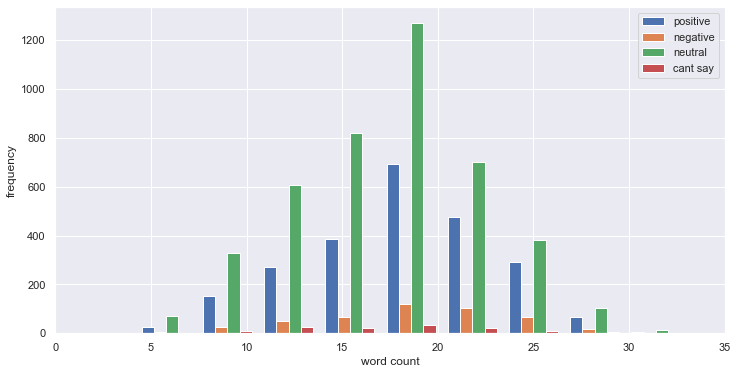

In [72]:
w = df_train['word count'][df_train.sentiment == 2]
x = df_train['word count'][df_train.sentiment == 0]
y = df_train['word count'][df_train.sentiment == 1]
z = df_train['word count'][df_train.sentiment == 3]
plt.figure(figsize=(12,6))
plt.xlim(0,35)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([w,x, y,z], label=['positive','negative','neutral','cant say'])
plt.legend(loc='upper right')

### majority of tweets have word count of 10 to 25

In [73]:
df_train['length'] = df_train.clean_tweet.str.len()

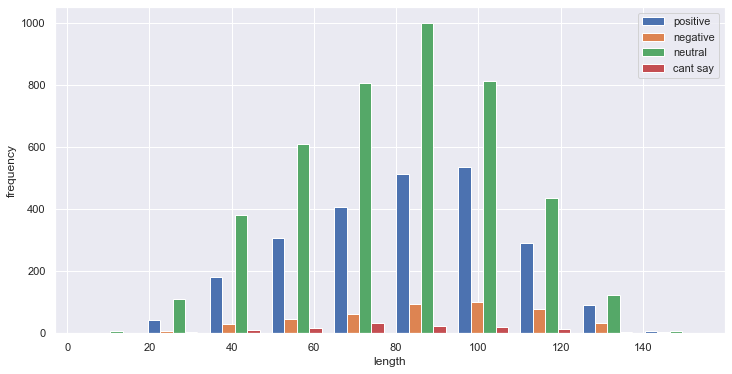

In [74]:
w = df_train['length'][df_train.sentiment == 2]
x = df_train['length'][df_train.sentiment == 0]
y = df_train['length'][df_train.sentiment == 1]
z = df_train['length'][df_train.sentiment == 3]
plt.figure(figsize=(12,6))
#plt.xlim(0,45)
plt.xlabel('length')
plt.ylabel('frequency')
g = plt.hist([w,x, y,z], label=['positive','negative','neutral','cant say'])
plt.legend(loc='upper right')

### majority of tweets have length between 20 to 100.Since data corresponding to max lenth n min length is less so it wont benefit the model


In [75]:
# Create a function to get the subjectivity
from textblob import TextBlob
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df_train['Subjectivity'] = df_train['clean_tweet'].apply(getSubjectivity)
df_train['Polarity'] = df_train['clean_tweet'].apply(getPolarity)

# Polarity

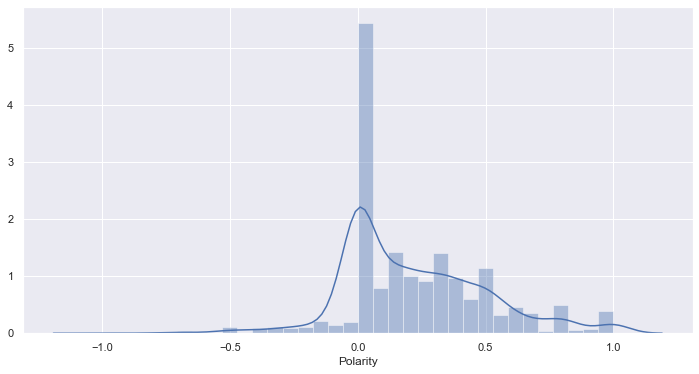

In [76]:
plt.figure(figsize=(12,6))
sns.distplot(df_train['Polarity'][df_train.sentiment == 2])
sns.set()

### As expected sentiment is positive so polarity is towards 1 but majority of the sentiment is centered toward zero which is not good.

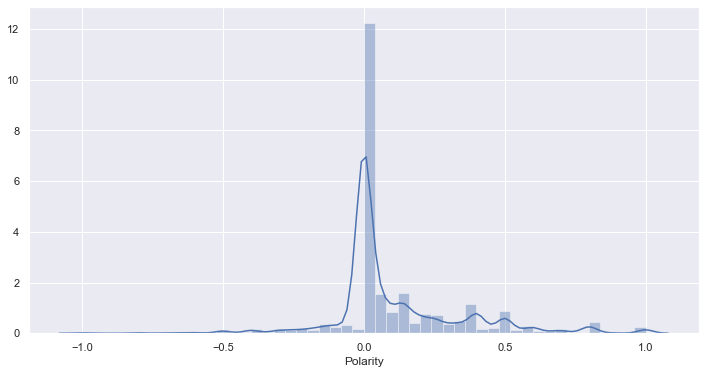

In [77]:
plt.figure(figsize=(12,6))
sns.distplot(df_train['Polarity'][df_train.sentiment == 1])
sns.set()

### As expected sentiment is neutral so polarity is around 0.0 but it is still right screwed

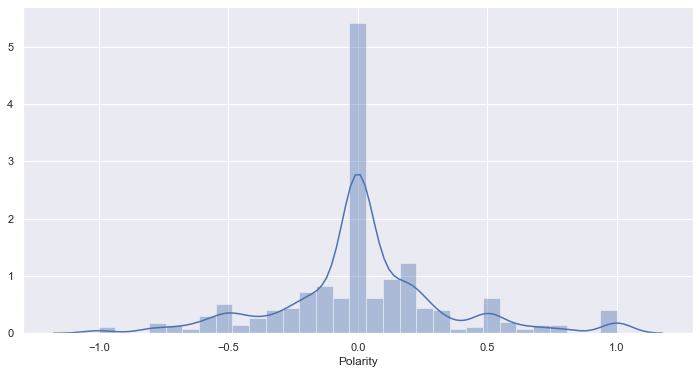

In [78]:
plt.figure(figsize=(12,6))
sns.distplot(df_train['Polarity'][df_train.sentiment == 0])
sns.set()

### But this didnot happend to  negative senti......the histogram is dispersed

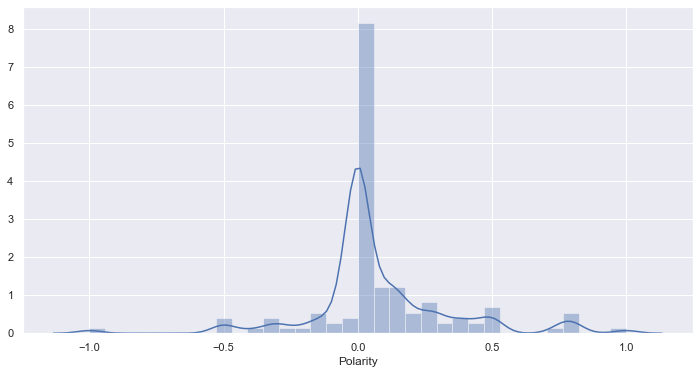

In [79]:
plt.figure(figsize=(12,6))
sns.distplot(df_train['Polarity'][df_train.sentiment == 3])
sns.set()

# Subjectivity

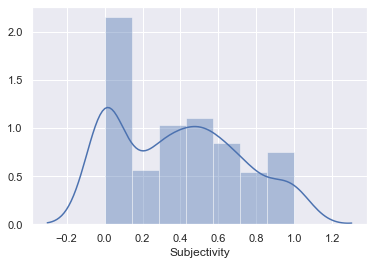

In [80]:
sns.distplot(df_train['Subjectivity'][df_train.sentiment == 0])

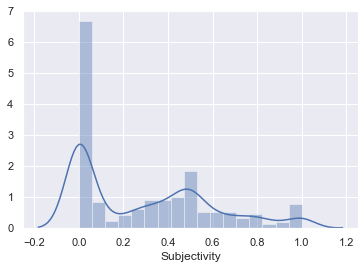

In [81]:
sns.distplot(df_train['Subjectivity'][df_train.sentiment == 1])

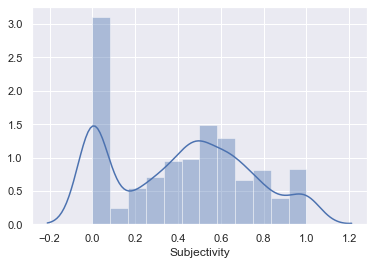

In [82]:
sns.distplot(df_train['Subjectivity'][df_train.sentiment == 2])

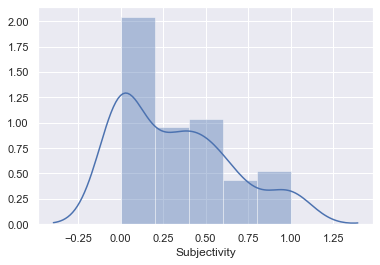

In [83]:
sns.distplot(df_train['Subjectivity'][df_train.sentiment == 3])

### From the histogram its clear that all tweets are quite objective and not subjective 

### Normalizing Data

In [84]:
# import packages
from nltk.corpus import stopwords
import nltk
from string import punctuation
from nltk.stem.porter import *
stop_words = list(set(stopwords.words('english')))

# tokenize
df_train['tokenized_text'] = [nltk.word_tokenize(x) for x in df_train['clean_tweet']]

# stopword removal
df_train['tokenized_text'] = df_train['tokenized_text'].apply(lambda row: [word for word in row if word not in stop_words])


In [85]:
sum(df_train['tokenized_text'],[])

['sxswnui',
 'sxsw',
 'apple',
 'defining',
 'language',
 'touch',
 'different',
 'dialects',
 'becoming',
 'smaller',
 'learning',
 'google',
 'doodles',
 'doodles',
 'light',
 'funny',
 'amp',
 'innovative',
 'exceptions',
 'significant',
 'occasions',
 'googledoodle',
 'sxsw',
 'one',
 'face',
 'stealing',
 'show',
 'yrs',
 'retweet',
 'quot',
 'sxsw',
 'apple',
 'schools',
 'mkt',
 'experetweets',
 'quot',
 'iphone',
 'sxsw',
 'app',
 'would',
 'pretty',
 'awesome',
 'crash',
 'every',
 'mins',
 'extended',
 'browsing',
 'fuckit',
 'illmakeitwork',
 'line',
 'outside',
 'apple',
 'store',
 'austin',
 'waiting',
 'new',
 'ipad',
 'sxsw',
 'technews',
 'one',
 'lone',
 'dude',
 'awaits',
 'ipad',
 'apple',
 'sxsw',
 'store',
 'tech',
 'news',
 'apple',
 'ipad',
 'sxsw',
 'tablets',
 'tech',
 'sxsw',
 'tips',
 'prince',
 'npr',
 'videos',
 'toy',
 'shopping',
 'zuckerberg',
 'sxsw',
 'ipad',
 'user',
 'retweet',
 'new',
 'ubersocial',
 'iphone',
 'app',
 'store',
 'includes',
 'ubergu

In [86]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image as im
mask = np.array(Image.open('C:\\Users\\Surojit Nath\\Downloads\\Twitter-featured.png'))

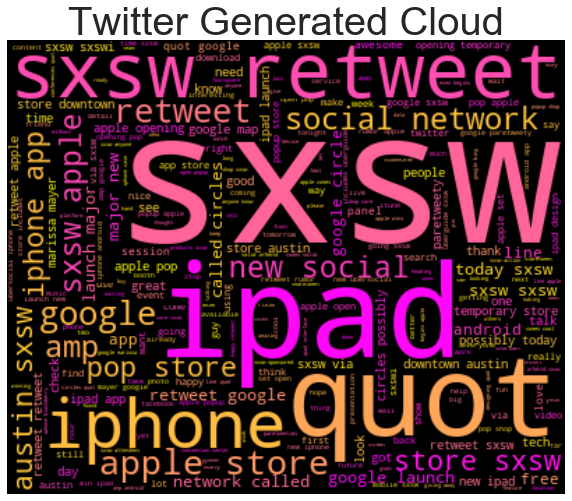

In [87]:
wc = WordCloud(background_color="black", max_words=3000, mask=mask,colormap='spring')
clean_string = ','.join(sum(df_train['tokenized_text'],[]))
wc.generate(clean_string)
f = plt.figure(figsize=(10,10))
#f.add_subplot(1,2, 1)
# plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
# plt.title('Original Stencil', size=40)
# plt.axis("off")
#f.add_subplot(1,2, 2)
plt.imshow(wc, interpolation='bilinear')
plt.title('Twitter Generated Cloud', size=40)
plt.axis("off")
plt.show()

In [88]:
#stemming words
stemmer = PorterStemmer()
df_train['tokenized_text_stemmer'] = df_train['tokenized_text'].apply(lambda x: [stemmer.stem(i) for i in x])
df_train['tokenized_text_stemmer'] = df_train['tokenized_text_stemmer'].apply(lambda x: ' '.join(x))
df_train.head(2)

,tweet_id,tweet,sentiment,count_mentions,clean_tweet,hashtags,word count,length,Subjectivity,Polarity,tokenized_text,tokenized_text_stemmer
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,0,sxswnui sxsw apple defining language touch with different dialects becoming smaller,3,12,83,0.65000,0.15000,"[sxswnui, sxsw, apple, defining, language, touch, different, dialects, becoming, smaller]",sxswnui sxsw appl defin languag touch differ dialect becom smaller
1,1851,"learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw",1,0,learning google doodles all doodles should light funny amp innovative with exceptions for significant occasions googledoodle sxsw,2,19,129,0.89375,0.38125,"[learning, google, doodles, doodles, light, funny, amp, innovative, exceptions, significant, occasions, googledoodle, sxsw]",learn googl doodl doodl light funni amp innov except signific occas googledoodl sxsw


In [89]:
# lemmatize every word
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df_train['tokenized_text_lemma'] = df_train['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
df_train['tokenized_text_lemma'] = df_train['tokenized_text_lemma'].apply(lambda x: ' '.join(x))
df_train.head(2)

,tweet_id,tweet,sentiment,count_mentions,clean_tweet,hashtags,word count,length,Subjectivity,Polarity,tokenized_text,tokenized_text_stemmer,tokenized_text_lemma
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,0,sxswnui sxsw apple defining language touch with different dialects becoming smaller,3,12,83,0.65000,0.15000,"[sxswnui, sxsw, apple, defining, language, touch, different, dialects, becoming, smaller]",sxswnui sxsw appl defin languag touch differ dialect becom smaller,sxswnui sxsw apple defining language touch different dialect becoming smaller
1,1851,"learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw",1,0,learning google doodles all doodles should light funny amp innovative with exceptions for significant occasions googledoodle sxsw,2,19,129,0.89375,0.38125,"[learning, google, doodles, doodles, light, funny, amp, innovative, exceptions, significant, occasions, googledoodle, sxsw]",learn googl doodl doodl light funni amp innov except signific occas googledoodl sxsw,learning google doodle doodle light funny amp innovative exception significant occasion googledoodle sxsw


# WordCloud

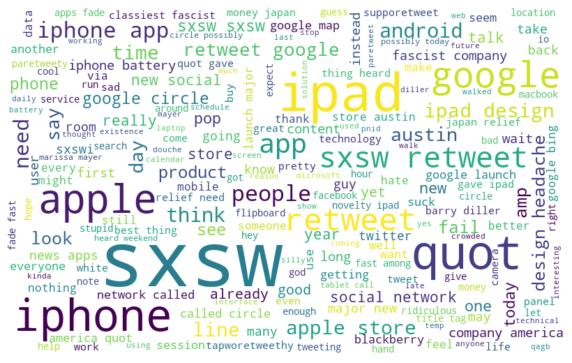

In [90]:
all_words = ' '.join([text for text in df_train['tokenized_text_lemma'][df_train['sentiment'] == 0]]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500,background_color='white', random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

### iphone google ipad and apple have negative comments words like ridiculous,suck,late,false alarm,hate,fail,fascist,headaches,sad,bad,stupid,fuckit indicate negativity n so our data is good to go

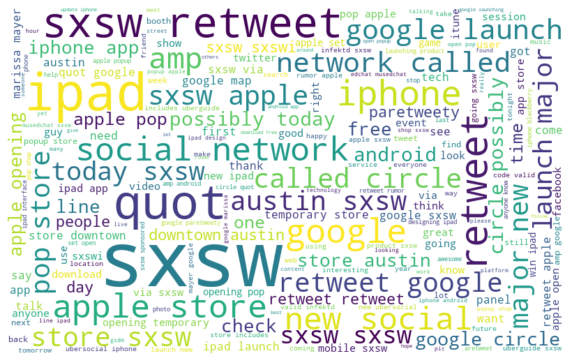

In [91]:
all_words = ' '.join([text for text in df_train['tokenized_text_lemma'][df_train['sentiment'] == 1]]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500,background_color='white', random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

### Words like Temporary,people,line,download,shop,austin,possibly,tech indicate Neutral comments

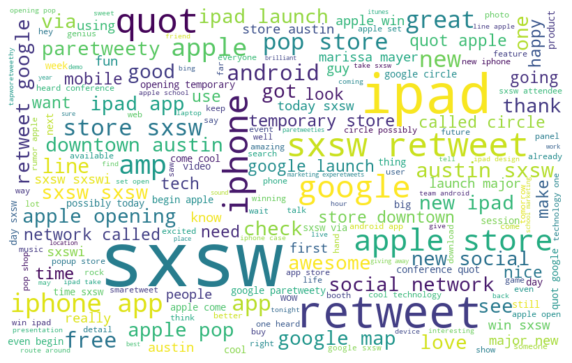

In [92]:
all_words = ' '.join([text for text in df_train['tokenized_text_lemma'][df_train['sentiment'] == 2]]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500,background_color='white', random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

### Words like love interesting,party winning, right,wow,great,good,wins,excited,heard well,strong rock indicate positive comments

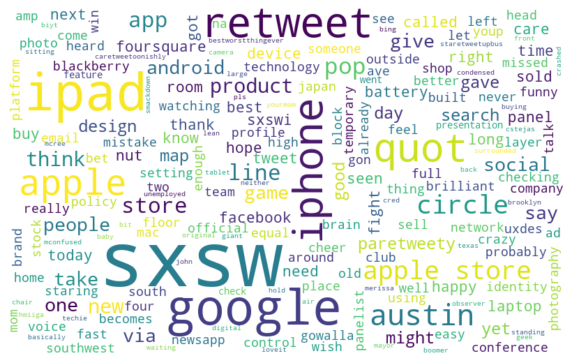

In [93]:
all_words = ' '.join([text for text in df_train['tokenized_text_lemma'][df_train['sentiment'] == 3]])  
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500,background_color='white', random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [95]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1600, stop_words='english') 
bow = bow_vectorizer.fit_transform(df_train['tokenized_text_stemmer']) 
bow.shape

(7256, 1600)

In [96]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1600, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_train['tokenized_text_stemmer']) 
tfidf.shape

(7256, 1600)

In [97]:
X = bow
y = df_train['sentiment']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2,random_state=0)
X_train_val,X_test_val,y_train_val,y_test_val = train_test_split(X_train,y_train, test_size = 0.2,random_state=0)

## Models

In [98]:
lreg = LogisticRegression() # training the model 
lreg.fit(X_train_val, y_train_val) 
prediction_val = lreg.predict(X_test_val) # predicting on the validation set prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0  
prediction_test = lreg.predict(X_test)
print(f1_score(y_test_val, prediction_val,average='weighted')) # calculating f1 score for the validation set
print(f1_score(y_test, prediction_test,average='weighted'))

0.6257344301205241
0.6327115577940334


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [99]:
# Instantiate calssifier
rf = RandomForestClassifier(random_state=0)

# fit model on training data
rf.fit(X_train_val,y_train_val)
prediction_val = rf.predict(X_test_val) # predicting on the validation set prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0  
prediction_test = rf.predict(X_test)
print(f1_score(y_test_val, prediction_val,average='weighted')) # calculating f1 score for the validation set
print(f1_score(y_test, prediction_test,average='weighted'))

0.6222450672882183
0.6440309321927362


In [100]:
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train_val, y_train_val) 
prediction_val = svc.predict(X_test_val) # predicting on the validation set prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0  
prediction_test = svc.predict(X_test)
print(f1_score(y_test_val, prediction_val,average='weighted')) # calculating f1 score for the validation set
print(f1_score(y_test, prediction_test,average='weighted'))

0.6117371310754606
0.6343550377312629


In [101]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth=10, n_estimators=1000,learning_rate=0.3).fit(X_train_val, y_train_val) 
prediction_val = xgb_model.predict(X_test_val) # predicting on the validation set prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0  
prediction_test = xgb_model.predict(X_test)
print(f1_score(y_test_val, prediction_val,average='weighted')) # calculating f1 score for the validation set
print(f1_score(y_test, prediction_test,average='weighted'))

0.6250133818611149
0.637418316798079


In [102]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.35,
                           depth=15,
                           loss_function='MultiClass')

In [103]:
model.fit(X_train_val, y_train_val)

0:	learn: 1.1420493	total: 5.29s	remaining: 8m 43s
1:	learn: 1.0393606	total: 10.2s	remaining: 8m 21s
2:	learn: 0.9698325	total: 15s	remaining: 8m 4s
3:	learn: 0.9246934	total: 19.2s	remaining: 7m 41s
4:	learn: 0.8984192	total: 23.4s	remaining: 7m 24s
5:	learn: 0.8809838	total: 27.5s	remaining: 7m 10s
6:	learn: 0.8662659	total: 31.7s	remaining: 7m 1s
7:	learn: 0.8552115	total: 35.8s	remaining: 6m 51s
8:	learn: 0.8448049	total: 40s	remaining: 6m 44s
9:	learn: 0.8358727	total: 44.6s	remaining: 6m 41s
10:	learn: 0.8295633	total: 49.4s	remaining: 6m 40s
11:	learn: 0.8255016	total: 53.9s	remaining: 6m 35s
12:	learn: 0.8200829	total: 58.5s	remaining: 6m 31s
13:	learn: 0.8109533	total: 1m 3s	remaining: 6m 32s
14:	learn: 0.8073442	total: 1m 9s	remaining: 6m 31s
15:	learn: 0.8037034	total: 1m 13s	remaining: 6m 24s
16:	learn: 0.7991503	total: 1m 17s	remaining: 6m 18s
17:	learn: 0.7943132	total: 1m 22s	remaining: 6m 15s
18:	learn: 0.7913177	total: 1m 27s	remaining: 6m 11s
19:	learn: 0.7844818	tot

KeyboardInterrupt: 

In [ ]:
prediction_val = model.predict(X_test_val) # predicting on the validation set prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0  
prediction_test = model.predict(X_test)
print(f1_score(y_test_val, prediction_val,average='weighted')) # calculating f1 score for the validation set
print(f1_score(y_test, prediction_test,average='weighted'))

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors], label=dtrain['sentiment'])
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['sentiment'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['sentiment'], dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['sentiment'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softmax',silent=True, nthread=1)

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time)

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)
# results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [ ]:
params={'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.8}
xgb = XGBClassifier(params=params,learning_rate=0.02, n_estimators=600, objective='multi:softmax',silent=True, nthread=1)
xgb.fit(X_train_val,y_train_val)

In [ ]:
prediction_val = xgb.predict(X_test_val) # predicting on the validation set prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0  
prediction_test = xgb.predict(X_test)
print(f1_score(y_test_val, prediction_val,average='weighted')) # calculating f1 score for the validation set
print(f1_score(y_test, prediction_test,average='weighted'))

# Test Data

In [ ]:
df_test =  pd.read_csv('./data/test.csv',encoding='utf-8')

In [ ]:
df_test.tweet.dropna(axis=0, inplace=True)

In [ ]:
df_test.reset_index(drop=True, inplace=True)

In [ ]:
df_test.drop_duplicates(['tweet'],inplace=True)
df_test.shape

In [ ]:
def count_regex(pattern, tweet):
    return len(re.findall(pattern, tweet))

In [ ]:
count_mentions = df_test['tweet'].astype(str).apply(lambda x:count_regex(r'@\w+', x))

In [ ]:
df_test['count_mentions'] = pd.DataFrame(count_mentions)

In [ ]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [ ]:
df_test['clean_tweet'] = df_test['tweet'].astype(str).apply(lambda x: lookup_dict(x,apostrophe_dict))
df_test.head(10)

In [ ]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda x: lookup_dict(x,short_word_dict))
df_test.head(90)

In [ ]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":@": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad",
":‑O": "suprise",
":O": "suprise",
":‑o": "suprise",
":o": "suprise",
":-0": "suprise",
"8‑0": "shock",
">:O": "yawn",
":‑|": "no expression",
":|": "indecision",
"|;‑)": "cool",
"|‑O": "bored",
"%‑)": "confused",
"%)": "confused",
"',:-|": "disaproval",
"',:-l": "disaproval"
}

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))
df_test.head(10)

In [ ]:
df_train['tweet'] = df_train['tweet'].str.lower()

In [ ]:
# function to collect hashtags 
def hashtag_extract(x):    
    hashtags = []    # Loop over the words in the tweet   
    for i in x:        
        ht = re.findall(r"#(\w+)", i)        
        hashtags.append(ht)     
    return hashtags

# extracting hashtags from negative tweets 
HT_negative = hashtag_extract(df_test['tweet'][df_test['sentiment'] == 0].astype(str)) 
# extracting hashtags from positive tweets 
HT_positive = hashtag_extract(df_test['tweet'][df_test['sentiment'] == 2].astype(str))
# extracting hashtags from neutral tweets
HT_neutral = hashtag_extract(df_test['tweet'][df_test['sentiment'] == 1].astype(str))
# extracting hashtags from cantsay tweets
HT_cantsay = hashtag_extract(df_test['tweet'][df_test['sentiment'] == 3].astype(str))

In [ ]:
HT_negative_s = sum(HT_negative,[])
HT_positive_s = sum(HT_positive,[])
HT_neutral_s = sum(HT_neutral,[])
HT_cantsay_s = sum(HT_cantsay,[])

In [ ]:
df_test['hashtags'] = df_test['tweet'].astype(str).apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df_train_sort_hashtags = df_train.sort_values(by='hashtags', ascending=False)
df_train_sort_hashtags[['tweet', 'hashtags']].head()

In [ ]:
# function to remove user handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, str(input_txt))
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return str(input_txt)

In [ ]:
# remove user handles
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda row:remove_pattern(row, "@[a-zA-Z0-9_]*"))

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda row:remove_pattern(row, "#"))

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].str.replace("[^a-zA-Z]", " ") 

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].str.lower()

In [ ]:
df_test['clean_tweet']=df_test['clean_tweet'].str.replace('rt','retweet')

In [ ]:
def RT_extract(x):    
    RTs = []    # Loop over the words in the tweet   
    for i in x:        
        rt = re.findall(r"retweet", i)        
        RTs.append(rt)     
    return RTs

In [ ]:
df_test[df_test['sentiment'] == 0].shape[0]

In [ ]:
retweet =[]
retweet_count =[]
for i in range(0,4):
    test=nltk.FreqDist(sum(RT_extract(df_test['clean_tweet'][df_test['sentiment'] == i]),[])) 
    retweet_count.append(test)
    retweet.append(test.get('retweet')*100/df_train[df_test['sentiment'] == i].shape[0])
    print(retweet_count[i],retweet[i])

In [ ]:
test.get('retweet')*100/df_test[df_test['sentiment'] == 1].shape[0]

In [ ]:
df_test[df_test['sentiment'] == 0].shape[0]

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].astype(str).apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [ ]:
df_test['clean_tweet']=df_test['clean_tweet'].str.replace('link','')

In [ ]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
df_test['word count'] = df_test['tweet'].astype(str).apply(word_count)
df_test.head(3)

In [ ]:
# Create a function to get the subjectivity
from textblob import TextBlob
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df_test['Subjectivity'] = df_test['clean_tweet'].apply(getSubjectivity)
df_test['Polarity'] = df_test['clean_tweet'].apply(getPolarity)

In [ ]:
# import packages
from nltk.corpus import stopwords
import nltk
from string import punctuation
from nltk.stem.porter import *
stop_words = list(set(stopwords.words('english')))

# tokenize
df_test['tokenized_text'] = [nltk.word_tokenize(x) for x in df_test['clean_tweet']]

# stopword removal
df_test['tokenized_text'] = df_test['tokenized_text'].apply(lambda row: [word for word in row if word not in stop_words])


In [ ]:
# lemmatize every word
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df_test['tokenized_text_lemma'] = df_test['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
df_test['tokenized_text_lemma'] = df_test['tokenized_text_lemma'].apply(lambda x: ' '.join(x))
df_test.head(2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1600, stop_words='english') 
bow = bow_vectorizer.fit_transform(df_test['tokenized_text_stemmer']) 
bow.shape

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1600, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_test['tokenized_text_stemmer']) 
tfidf.shape

In [ ]:
X = bow

In [ ]:
prediction_test = lreg.predict(X)

In [ ]:
finalpred=pd.concat([new,pd.DataFrame(prediction_test,columns=['sentiment'])],1)
finalpred.to_csv("sentiment01.csv",index=False)